#### KerasのモデルをTensorRTに変更する方法

VGG16の学習済みモデルを取得します。

In [0]:
import warnings

warnings.filterwarnings('ignore')
from keras.applications import mobilenetv2
import tensorflow as tf

from keras import backend as K
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions

# with network
model = mobilenetv2.MobileNetV2(weights='imagenet')
model.save('mobilenetv2.h5')


Using TensorFlow backend.


学習済みモデルをロードします。KerasでTensorFlowをバックエンドで使用する際に発生する警告です。

In [0]:
model = load_model('mobilenetv2.h5')

W0823 10:43:35.189765 548179341328 deprecation_wrapper.py:119] From /home/jetson/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 10:43:35.809341 548179341328 deprecation_wrapper.py:119] From /home/jetson/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 10:43:36.010588 548179341328 deprecation_wrapper.py:119] From /home/jetson/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 10:43:36.013347 548179341328 deprecation_wrapper.py:119] From /home/jetson/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 1

画像データを取得し、表示します。

バッチ処理できるようにバッチサイズ分、確保したデータを用意します。

In [0]:
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time
%matplotlib inline

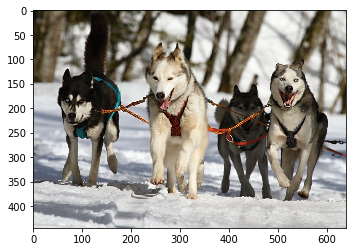

In [0]:
# 自身で用意したデータをお使いください
IMAGE_PATH = './data/huskies.jpg'
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((224, 224)))
image = np.array(image_resized)

batch_size = 16
image_array = []
for i in range(batch_size):
    image_array.append(image)
  
image_array = np.array(image_array)

`mobilenetv2`の前処理を行います。

In [0]:
preprocess_image = mobilenetv2.preprocess_input(image_array)

Kerasのモデルで推論します。GPUの初期化の問題で最初の推論は遅いので数回の推論後に推論速度を計測します。

In [0]:
for i in range(3):
    scores = model.predict(preprocess_image[:1, ...])
t0 = time.time()
scores = model.predict(preprocess_image[:1, ...])
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0)))

Average runtime: 0.092096 seconds


KerasのモデルをTensorFlowグラフに変更します。

In [0]:
shape = model.input_shape
x_name = 'image_tensor_x'

with K.get_session() as sess:
    # 入力のTensorを定義。TensorFlowではTensorだけを定義して後で値が入力されるのでこの形式で定義します。
    x_tensor = tf.placeholder(tf.float32, shape, x_name)
    # 学習しないように0に設定して値を固定します
    K.set_learning_phase(0)
    # 推論のTensorを導出します。
    y_tensor = model(x_tensor)
    # 推論のTensor名を取得します。今回のモデルではy_tensor.nameで'mobilenetv2_1.00_224/Logits/Softmax:0'が得られます
    # が－2にしている理由は末尾の':0'がモデル内にはないためになります
    y_name = y_tensor.name[:-2]
    # TensorFlowで扱うグラフ表現を取得します。
    graph = sess.graph.as_graph_def()
    # グラフ内の変数を同じ値の固定値で置き換えます。
    graph0 = tf.compat.v1.graph_util.convert_variables_to_constants(sess, graph, [y_name])
    # 推論のみなのでグラフ上の学習ノードを削除します。
    graph1 = tf.compat.v1.graph_util.remove_training_nodes(graph0)

W0823 10:45:43.615310 548179341328 deprecation.py:323] From <ipython-input-7-8f8153c9b3d9>:17: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0823 10:45:43.618364 548179341328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W0823 10:45:47.194371 548179341328 deprecation.py:323] From <ipython-input-7-8f8153c9b3d9>:19: remove_training_nodes (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


TensorFlowのモデルをTensorRTに変換します。

In [0]:
%%time
import tensorflow.contrib.tensorrt as trt

trt_graph_def = trt.create_inference_graph(
  graph1,
  outputs=[y_name],
  max_batch_size=1,
  max_workspace_size_bytes=1 << 20,
  precision_mode="FP16",
  minimum_segment_size=20
)

CPU times: user 29.7 s, sys: 11.5 s, total: 41.2 s
Wall time: 1min 22s


TensorRTエンジンを読み込んで推論します。TensorRTの初回の推論は初期化の関係上、遅いのであらかじめ推論しておきます。

- 推論処理をしています。`feed_dict`でTensorの名前と実際の入力値を紐づけてTensorRTエンジンに渡しています。
```
scores = tf_sess.run([tf_scores], feed_dict={
    tf_input: preprocess_image[:1, ...]
})
```

In [0]:
%%time

tf.reset_default_graph()

tf_sess = tf.Session()

# TensorRTに変換したモデルを読み込みます。
tf.import_graph_def(trt_graph_def, name='')

# 出力のTensorの名前を設定します。
tf_scores = tf_sess.graph.get_tensor_by_name(y_name + ':0')
# 入力のTensorの名前を設定します。
tf_input = tf_sess.graph.get_tensor_by_name(x_name + ':0')

CPU times: user 1.12 s, sys: 60 ms, total: 1.18 s
Wall time: 2.02 s


In [0]:
for i in range(3):
    scores = tf_sess.run([tf_scores], feed_dict={
        tf_input: preprocess_image[:1, ...]
    })


t0 = time.time()
scores = tf_sess.run([tf_scores], feed_dict={
    tf_input: preprocess_image[:1, ...]
})
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0)))

# first time with network
print(decode_predictions(scores[0]))

Average runtime: 0.032450 seconds
[[('n03218198', 'dogsled', 0.96569157), ('n02109961', 'Eskimo_dog', 0.01988572), ('n02110185', 'Siberian_husky', 0.0009327496), ('n02091831', 'Saluki', 0.00038181344), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.00020880827)]]


"dogsled"は犬ぞりの意味になります。decode_predictionsの初回起動にはネットワーク接続が必要になります。